# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

import matplotlib.pyplot as plt
import seaborn as sns

import scikitplot as skplt
from sklearn.model_selection import StratifiedShuffleSplit as sss

from imblearn.ensemble import BalancedRandomForestClassifier

## 0.1 Load data

In [2]:
home_path = "/home/marcos/Documentos/comunidade_DS/pa004_health_insurance_cross_sell/"

In [3]:
df_tree_train = pd.read_pickle(home_path + "interim/df6_bal_tree_train.pkl")

df_tree_validation = pd.read_pickle(home_path + "interim/df6_bal_tree_val.pkl")

## 0.2 Separate train and validation data

In [4]:
df7_train = df_tree_train.copy()

df7_validation = df_tree_validation.copy()

In [5]:
df7_train.isna().sum()

vintage                 0
annual_premium          0
age                     0
region_code             0
policy_sales_channel    0
vehicle_hist            0
vehicle_damage          0
previously_insured      0
weight_ages             0
id                      0
response                0
dtype: int64

In [6]:
df7_validation.isna().sum()

vintage                 0
annual_premium          0
age                     0
region_code             0
policy_sales_channel    3
vehicle_hist            0
vehicle_damage          0
previously_insured      0
weight_ages             0
id                      0
response                0
dtype: int64

In [7]:
df7_validation.dropna(axis=0, inplace=True)
df7_validation.isna().sum()

vintage                 0
annual_premium          0
age                     0
region_code             0
policy_sales_channel    0
vehicle_hist            0
vehicle_damage          0
previously_insured      0
weight_ages             0
id                      0
response                0
dtype: int64

## 0.3 Helper Functions

In [8]:
# precision_at_k
def precision_at_k(data, k):
    data = data.reset_index(drop=True)
    data['n_samples'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
    return data.loc[k, 'precision_at_k']

# recall_at_k
def recall_at_k(data, k):
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']

# model predict
def model_evaluate(model, model_name, data_train, data_val, k):
    # separate X and Y data:
    xtrain = data_train.drop(['id', 'response'], axis=1)
    ytrain = data_train.response
    xval = data_val.drop(['id', 'response'], axis=1)
    yval = data_val.response
    
    # fit and predict_proba:
    model.fit(xtrain, ytrain)
    yhat_proba = model.predict_proba(xval)
    
    # transform yhat_proba to 1D-array
    yhat_proba_1d = yhat_proba[:, 1].tolist()
    
    # include in dataframe
    validation_data = data_val.copy()
    validation_data['score'] = yhat_proba_1d
    # sort
    validation_data = validation_data.sort_values('score', ascending=False)
    
    # plot
    skplt.metrics.plot_cumulative_gain(yval, yhat_proba);
    
    return pd.DataFrame({'Model name':model_name,
                         'precision_at_k':precision_at_k(validation_data, k),
                         'recall_at_k':recall_at_k(validation_data, k)}, index=[0])

# model fit
def model_fit(model, data):
    # separate X and Y data:
    xtrain = data.drop(['id', 'response'], axis=1)
    ytrain = data.response
    
    # fit
    model_fitted = model.fit(xtrain, ytrain)
    
    return model_fitted



def cross_validation(model, model_name, training_data, k_top, kfolds, verbose=False):
    # X separate X and Y data:
    xtraining = training_data.drop(['response'], axis=1)
    ytraining = training_data.response
    
    # cross-validation:
    cv = sss(n_splits=kfolds)
    prec_k_list = []
    rec_k_list = []
    for train_index, prim_val_index in cv.split(xtraining, ytraining):
        X_training, X_prim_val = xtraining.iloc[train_index], xtraining.iloc[prim_val_index]
        y_training, y_prim_val = ytraining.iloc[train_index], ytraining.iloc[prim_val_index]
        
        # remove id from training, and create new validation without id
        X_training = X_training.drop(['id'], axis=1)
        X_prim_val_no_id = X_prim_val.drop(['id'], axis=1)
        
        # fit and predict_proba
        model.fit(X_training, y_training)
        yhat_proba = model.predict_proba(X_prim_val_no_id)
        
        # transform yhat_proba to 1D-array
        yhat_proba_1d = yhat_proba[:, 1].tolist()
        
        # reconstruct dataframe
        prim_val = pd.concat([X_prim_val, y_prim_val], axis=1)
        prim_val['score'] = yhat_proba_1d
        prim_val = prim_val.sort_values('score', ascending=False)
        
        # evaluate accuracy and store in list
        prec_k_list.append(precision_at_k(prim_val, k_top))
        rec_k_list.append(recall_at_k(prim_val, k_top))
    
    #evaluate mean and std
    prec_k_pred = np.round(np.mean(prec_k_list), 4).astype(str) + '+/-' + np.round(np.std(prec_k_list), 4).astype(str)
    rec_k_pred = np.round(np.mean(rec_k_list), 4).astype(str) + '+/-' + np.round(np.std(rec_k_list), 4).astype(str)
    
    return pd.DataFrame({'Model name':model_name,
                         'precision_at_k':prec_k_pred,
                         'recall_at_k':rec_k_pred}, index=[0])

# 8.0 Hyperparameter Fine Tunning

## 8.1 Balanced Random Forest Classifier

In [9]:
param = {'n_estimators':[300, 400, 500],
         'max_depth':[3, 5, 9],
         'oob_score': [True, False],
         'class_weight':[None, 'balanced', 'balanced_subsample']
        }

MAX_EVAL = 5

In [10]:
final_result = pd.DataFrame()
hyperparam_lst = []

for i in range(MAX_EVAL):
    #randomly selected hyperparameters
    hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
    #print the selected ones
    print(hp)
    #store in list
    hyperparam_lst.append(hp.copy())
    #model
    model = BalancedRandomForestClassifier(n_estimators=hp['n_estimators'],
                                           max_depth=hp['max_depth'],
                                           bootstrap=True,
                                           oob_score=hp['oob_score'],
                                           sampling_strategy=0.15,
                                           replacement=True,
                                           random_state=30,
                                           n_jobs=-1,
                                           class_weight=hp['class_weight'])
    result = cross_validation(model, 'Balanced Random Forest Classifier', df7_train, 20000, 5)
    iter_nr = pd.Series([i], name='Iter_nr')
    result_w_nr = pd.concat([result, iter_nr], axis=1)
    final_result = pd.concat([final_result, result_w_nr], ignore_index=True)

final_result.sort_values(by=['precision_at_k'], ascending=False, inplace=True, ignore_index=True)
final_result

{'n_estimators': 400, 'max_depth': 3, 'oob_score': False, 'class_weight': 'balanced_subsample'}
{'n_estimators': 400, 'max_depth': 9, 'oob_score': False, 'class_weight': None}
{'n_estimators': 500, 'max_depth': 3, 'oob_score': True, 'class_weight': None}
{'n_estimators': 400, 'max_depth': 9, 'oob_score': True, 'class_weight': 'balanced'}
{'n_estimators': 300, 'max_depth': 5, 'oob_score': True, 'class_weight': None}


,Model name,precision_at_k,recall_at_k,Iter_nr
0,Balanced Random Forest Classifier,0.1867+/-0.0001,0.9991+/-0.0004,1
1,Balanced Random Forest Classifier,0.1867+/-0.0001,0.9995+/-0.0006,2
2,Balanced Random Forest Classifier,0.1867+/-0.0001,0.9992+/-0.0005,4
3,Balanced Random Forest Classifier,0.1867+/-0.0,0.9994+/-0.0002,0
4,Balanced Random Forest Classifier,0.1867+/-0.0,0.9991+/-0.0002,3


In [11]:
final_result.to_pickle(home_path + 'interim/bal_rf_cv.pkl')

In [12]:
# select the hyperparameters that resulted in best precision
best_param_nr = final_result.loc[0, 'Iter_nr']

param_tuned = hyperparam_lst[best_param_nr]

In [13]:
#model
model_tuned = BalancedRandomForestClassifier(n_estimators=param_tuned['n_estimators'],
                                             max_depth=param_tuned['max_depth'],
                                             bootstrap=True,
                                             oob_score=param_tuned['oob_score'],
                                             sampling_strategy=0.15,
                                             replacement=True,
                                             random_state=30,
                                             n_jobs=-1,
                                             class_weight=param_tuned['class_weight'])

,Model name,precision_at_k,recall_at_k
0,Balanced Random Forest Classifier,0.329984,0.706487


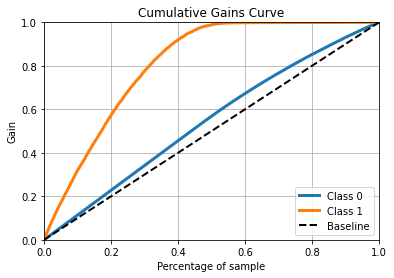

In [14]:
model_tuned_ranking = model_evaluate(model_tuned, "Balanced Random Forest Classifier", df7_train, df7_validation, 20000)

model_tuned_ranking

In [15]:
bal_rf_tuned = model_fit(model_tuned, df7_train)

In [16]:
pickle.dump(bal_rf_tuned, open(home_path + "ml_models_comp/giant/bal_rf_tuned.pkl", "wb"))

### 8.1.1 Validation

{'n_estimators': 400, 'max_depth': 3, 'oob_score': False, 'class_weight': 'balanced_subsample'}
{'n_estimators': 400, 'max_depth': 9, 'oob_score': False, 'class_weight': None}
{'n_estimators': 500, 'max_depth': 3, 'oob_score': True, 'class_weight': None}
{'n_estimators': 400, 'max_depth': 9, 'oob_score': True, 'class_weight': 'balanced'}
{'n_estimators': 300, 'max_depth': 5, 'oob_score': True, 'class_weight': None}


,Model name,precision_at_k,recall_at_k,Iter_nr
0,Balanced Random Forest Classifier,0.330333,0.707236,3
1,Balanced Random Forest Classifier,0.329984,0.706487,1
2,Balanced Random Forest Classifier,0.322934,0.691394,4
3,Balanced Random Forest Classifier,0.318634,0.682188,0
4,Balanced Random Forest Classifier,0.317934,0.680689,2


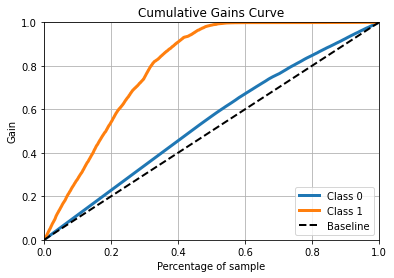

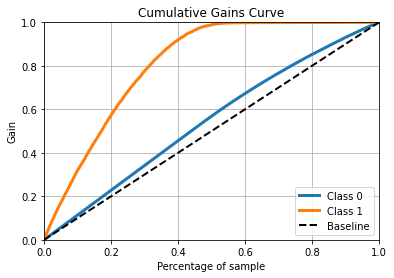

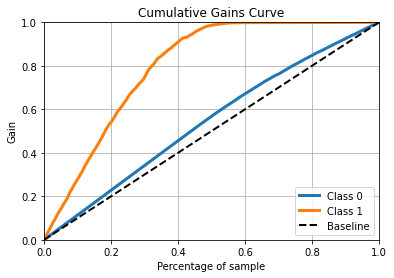

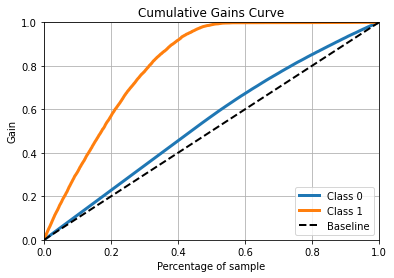

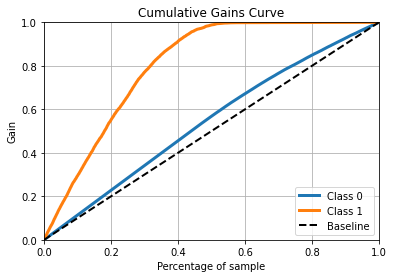

In [17]:
validation_result = pd.DataFrame()

for j in range(len(hyperparam_lst)):
    param_dict = hyperparam_lst[j]
    # print results
    print(param_dict)
    
    #model
    model = BalancedRandomForestClassifier(n_estimators=param_dict['n_estimators'],
                                           max_depth=param_dict['max_depth'],
                                           bootstrap=True,
                                           oob_score=param_dict['oob_score'],
                                           sampling_strategy=0.15,
                                           replacement=True,
                                           random_state=30,
                                           n_jobs=-1,
                                           class_weight=param_dict['class_weight'])
    result = model_evaluate(model, 'Balanced Random Forest Classifier', df7_train, df7_validation, 20000)
    iter_nr = pd.Series([j], name='Iter_nr')
    result_w_nr = pd.concat([result, iter_nr], axis=1)
    validation_result = pd.concat([validation_result, result_w_nr], ignore_index=True)

validation_result.sort_values(by=['recall_at_k'], ascending=False, inplace=True, ignore_index=True)
validation_result

In [18]:
# select the hyperparameters that resulted in best recall
best_param_nr = validation_result.loc[0, 'Iter_nr']

param_validated = hyperparam_lst[best_param_nr]

,Model name,precision_at_k,recall_at_k
0,Balanced Random Forest Classifier,0.330333,0.707236


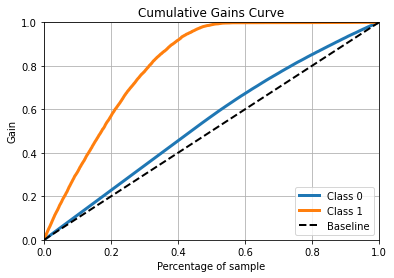

In [19]:
# model
model = BalancedRandomForestClassifier(n_estimators=param_validated['n_estimators'],
                                       max_depth=param_validated['max_depth'],
                                       bootstrap=True,
                                       oob_score=param_validated['oob_score'],
                                       sampling_strategy=0.15,
                                       replacement=True,
                                       random_state=30,
                                       n_jobs=-1,
                                       class_weight=param_validated['class_weight'])

bal_rf_rank = model_evaluate(model, "Balanced Random Forest Classifier", df7_train, df7_validation, 20000)
bal_rf_rank

In [20]:
bal_rf_validated = model_fit(model, df7_train)

In [21]:
pickle.dump(bal_rf_validated, open(home_path + "ml_models_comp/giant/bal_rf_validated.pkl", "wb"))